# LiDAR Uncertainty: A Comparison of Two California Sites.

## The San Joaquin Experimental Range Site
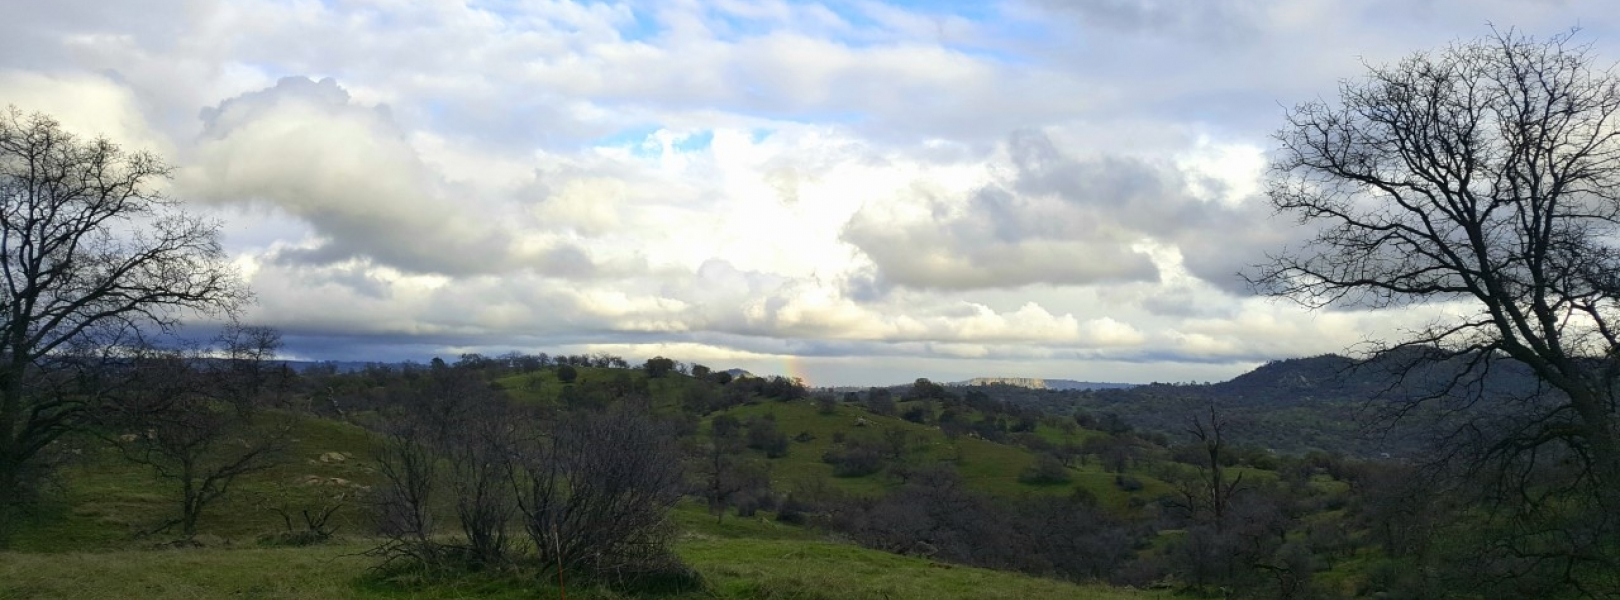
image credit: National Ecological Observation Network

## The Soaproot Saddle NEON Site
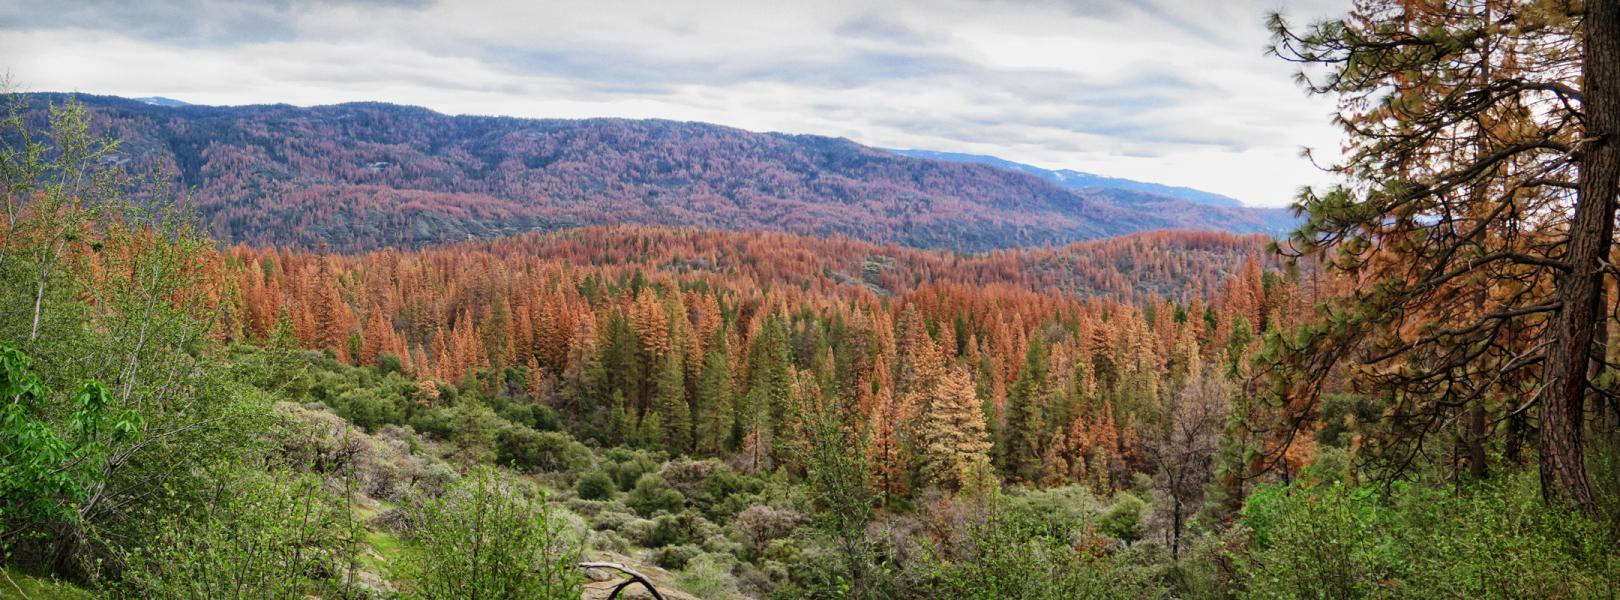
image credit: National Ecological Observation Network

In [2]:
# Import necessary packages
import os
import pathlib

import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterstats as rs
import rioxarray as rxr
import seaborn as sns
import xarray as xr

# Download data from earth py
et.data.get_data('spatial-vector-lidar')

# General housekeeping
home_dir = os.path.join(pathlib.Path.home(), 'earth-analytics',
                        'data', 'spatial-vector-lidar')
os.chdir(home_dir)

# If the dir does not exist, create it
output_path = os.path.join(home_dir,
                           "outputs")

In [3]:
class NEONDataLoader:

    '''This class creates all of our necessary paths for downloads

    parameters:
    ----------
    site_name = str
    id_col = str
    formatting_dict = key (?)

    returns:
    -------
    Data is opened and transferred to correct locations.
    '''

    # Create necessary variables for SOAP and SJER sites.
    base_dir_tmpl = os.path.join('california',
                                 'neon-{site_name_low}-site')

    insitu_path_tmpl = os.path.join('{base_dir}', '2013',
                                    'insitu', 'veg{separator}structure',
                                    'D17_2013_{site_name_up}_vegStr.csv')
    plots_path_tmpl = os.path.join(
        '{base_dir}', 'vector_data', '{site_name_up}{plot}_centroids.shp')
    chm_path_tmpl = os.path.join(
        '{base_dir}', '2013', 'lidar', '{site_name_up}_lidarCHM.tif')

    # Create init function download both sets of data.
    def __init__(self, site_name, id_col, formatting_dict={}):
        self.site_name = site_name
        self.id_col = id_col
        self.formatting_dict = formatting_dict
        self.formatting_dict['site_name_low'] = site_name.lower()
        self.formatting_dict['site_name_up'] = site_name.upper()
        self.formatting_dict['base_dir'] = self.base_dir_tmpl.format(
            **self.formatting_dict)

        self.insitu_path = self.insitu_path_tmpl.format(**self.formatting_dict)
        self.plots_path = self.plots_path_tmpl.format(**self.formatting_dict)
        self.chm_path = self.chm_path_tmpl.format(**self.formatting_dict)

In [4]:
sjer_data_loader = NEONDataLoader('SJER', 'Plot_ID',
                                  {'separator': '_', 'plot': '_plot'})
sjer_data_loader

In [5]:
soap_data_loader=NEONDataLoader('SOAP', 'ID', 
                                {'separator':'-', 'plot':''})

soap_data_loader.insitu_path

'california\\neon-soap-site\\2013\\insitu\\veg-structure\\D17_2013_SOAP_vegStr.csv'

In [91]:
class AnalyzeLidarUncertainty:

    '''This class calculates stats for lidar and insitu and merges the two data frames.

        parameters:
        ----------
        lidar_path: str (or path?) 
        insitu_path: str
        plots_path: str

        returns:
        -------
        Processed data frame.

        '''

    def __init__(self, lidar_path, insitu_path, plots_path, study_site):
        self.lidar_path = lidar_path
        self.insitu_path = insitu_path
        self.plots_path = plots_path
        self.study_site = study_site

    def calc_lidar_chm_stats(self):
        '''
        Calculates lidar mean and max tree heights.
        '''

        lidar_chm = rxr.open_rasterio(
            self.lidar_path, masked=True).squeeze()
        lidar_chm_clean = lidar_chm.where(lidar_chm > 0, np.nan)

        plots_gdf = gpd.read_file(self.plots_path)
        plots_gdf.geometry = plots_gdf.geometry.buffer(20)

        lidar_chm_stats = rs.zonal_stats(
            plots_gdf,
            lidar_chm_clean.values,
            affine=lidar_chm_clean.rio.transform(),
            nodata=-999,
            geojson_out=True,
            copy_properties=True,
            stats='count mean max')

        # Create a gdf based on the stats requested from zonal stats and rename columns.
        lidar_chm_gdf = gpd.GeoDataFrame.from_features(lidar_chm_stats)

        lidar_chm_gdf.rename(
            columns={'max': 'lidar_max',
                     'mean': 'lidar_mean',
                     'ID': 'plotid',
                     'Plot_ID': 'plotid'}, inplace=True)

        return lidar_chm_gdf

    def calc_insitu_dfs(self):
        '''
        Calculate insitu tree height mean and max.
        '''

        df = (pd.read_csv(self.insitu_path)
              .groupby('plotid')
              .stemheight
              .agg(['max', 'mean'])
              .rename(columns={'max': 'insitu_max',
                               'mean': 'insitu_mean',
                               'ID': 'plotid',
                               'Plot_ID': 'plotid'}))

        return df

    def merge_dfs(self):
        '''
        Merges insitu and lidar data frames together.

        '''

        chm_stats_gdf = self.calc_lidar_chm_stats()
        insitu_height_df = self.calc_insitu_dfs()

        if (self.study_site == 'soap'):
            ss = self.study_site.upper()
            chm_stats_gdf['plotid'] = ss + chm_stats_gdf['plotid']

        data_frame = chm_stats_gdf.merge(
            insitu_height_df, right_on='plotid', left_on='plotid')
        return data_frame


sjer_site = AnalyzeLidarUncertainty(
    sjer_data_loader.chm_path, sjer_data_loader.insitu_path,
    sjer_data_loader.plots_path, sjer_data_loader.formatting_dict['site_name_low'])

sjer_site.calc_lidar_chm_stats()

geometry    plotid   Point  \
0   POLYGON ((255872.376 4111567.818, 255872.280 4...  SJER1068  center   
1   POLYGON ((257426.967 4111298.971, 257426.871 4...   SJER112  center   
2   POLYGON ((256858.760 4110819.876, 256858.664 4...   SJER116  center   
3   POLYGON ((256196.947 4108752.026, 256196.851 4...   SJER117  center   
4   POLYGON ((255988.372 4110476.079, 255988.276 4...   SJER120  center   
5   POLYGON ((257098.867 4111388.570, 257098.771 4...   SJER128  center   
6   POLYGON ((256703.434 4111071.087, 256703.338 4...   SJER192  center   
7   POLYGON ((256737.467 4112167.778, 256737.371 4...   SJER272  center   
8   POLYGON ((256054.390 4111533.879, 256054.294 4...  SJER2796  center   
9   POLYGON ((258517.102 4109856.983, 258517.006 4...  SJER3239  center   
10  POLYGON ((258297.829 4110161.674, 258297.733 4...    SJER36  center   
11  POLYGON ((256981.794 4107527.074, 256981.698 4...   SJER361  center   
12  POLYGON ((256168.197 4107578.841, 256168.101 4...    SJER37  center   
13  POLYGON ((257248.336 4109767.289, 257248.240 4...     SJER4  center   
14  POLYGON ((254758.618 4110249.265, 254758.522 4...     SJER8  center   
15  POLYGON ((256205.584 4110047.586, 256205.488 4...   SJER824  center   
16  POLYGON ((257480.486 4109616.679, 257480.390 4...   SJER916  center   
17  POLYGON ((255891.194 4110759.039, 255891.098 4...   SJER952  center   

       northing     easting plot_type  lidar_max  lidar_mean  count  
0   4111567.818  255852.376     trees  19.049999   11.544347    161  
1   4111298.971  257406.967     trees  24.019999   10.369277    443  
2   4110819.876  256838.760     grass  16.070000    7.518398    643  
3   4108752.026  256176.947     trees  11.059999    7.675346    245  
4   4110476.079  255968.372     grass   5.740000    4.591177     17  
5   4111388.570  257078.867     trees  19.139999    8.987087    381  
6   4111071.087  256683.434     grass  16.549999    7.229096    929  
7   4112167.778  256717.467     trees  11.840000    7.107061    711  
8   4111533.879  256034.390      soil  20.279999    6.409630    270  
9   4109856.983  258497.102      soil  12.910000    6.009128    195  
10  4110161.674  258277.829     trees   8.990000    6.516288     97  
11  4107527.074  256961.794     grass  18.730000   13.899028     72  
12  4107578.841  256148.197     trees  11.490000    7.109850    201  
13  4109767.289  257228.336     trees   9.530000    5.034937    395  
14  4110249.265  254738.618     trees   4.150000    3.024286      7  
15  4110047.586  256185.584      soil  25.660000    7.720838    382  
16  4109616.679  257460.486      soil  18.730000   11.170795    264  
17  4110759.039  255871.194     grass   6.380000    4.149285     42

In [84]:
soap_site = AnalyzeLidarUncertainty(soap_data_loader.chm_path, soap_data_loader.insitu_path,
                                    soap_data_loader.plots_path, soap_data_loader.formatting_dict['site_name_low'])
soap_site.calc_lidar_chm_stats()

geometry  OBJECTID plotid  \
0   POLYGON ((297815.197 4101493.028, 297815.101 4...         1     27   
1   POLYGON ((297065.197 4100713.028, 297065.101 4...         2     43   
2   POLYGON ((299825.197 4101013.028, 299825.101 4...         3     63   
3   POLYGON ((298175.197 4101433.028, 298175.101 4...         4     91   
4   POLYGON ((298715.197 4100833.028, 298715.101 4...         5     95   
5   POLYGON ((297065.197 4100083.028, 297065.101 4...         6    139   
6   POLYGON ((299885.197 4100413.028, 299885.101 4...         7    143   
7   POLYGON ((297545.197 4100533.028, 297545.101 4...         8    187   
8   POLYGON ((298775.197 4101403.028, 298775.101 4...         9    287   
9   POLYGON ((297515.197 4100683.028, 297515.101 4...        10    299   
10  POLYGON ((297065.197 4100593.028, 297065.101 4...        11    331   
11  POLYGON ((298955.197 4100743.028, 298955.101 4...        12    351   
12  POLYGON ((299765.197 4101493.028, 299765.101 4...        13    383   
13  POLYGON ((299615.197 4100413.028, 299615.101 4...        14    399   
14  POLYGON ((300575.197 4100653.028, 300575.101 4...        15    422   
15  POLYGON ((300455.197 4100443.028, 300455.101 4...        16    438   
16  POLYGON ((300275.197 4100653.028, 300275.101 4...        17    447   
17  POLYGON ((299285.197 4101313.028, 299285.101 4...        18    479   
18  POLYGON ((297575.197 4101313.028, 297575.101 4...        19    539   
19  POLYGON ((299675.197 4101493.028, 299675.101 4...        20    639   
20  POLYGON ((298565.197 4100113.028, 298565.101 4...        21    687   
21  POLYGON ((296975.197 4100083.028, 296975.101 4...        22    715   
22  POLYGON ((299315.197 4101463.028, 299315.101 4...        23    223   
23  POLYGON ((297785.197 4101193.028, 297785.101 4...        24    283   
24  POLYGON ((299165.197 4101433.028, 299165.101 4...        25    991   
25  POLYGON ((298085.197 4100653.028, 298085.101 4...        26   1435   
26  POLYGON ((297455.197 4100563.028, 297455.101 4...        27   1611   
27  POLYGON ((297815.197 4100083.028, 297815.101 4...        28   1915   
28  POLYGON ((298385.197 4101343.028, 298385.101 4...        29   2907   
29  POLYGON ((297185.197 4101043.028, 297185.101 4...        30   3627   
30  POLYGON ((299705.197 4101163.028, 299705.101 4...        53    127   
31  POLYGON ((298235.197 4101103.028, 298235.101 4...        54    155   
32  POLYGON ((298175.197 4100773.028, 298175.101 4...        55    411   
33  POLYGON ((299225.197 4100923.028, 299225.101 4...        56    415   
34  POLYGON ((298415.197 4100863.028, 298415.101 4...        57    667   
35  POLYGON ((299225.197 4101073.028, 299225.101 4...        58   1439   
36  POLYGON ((298085.197 4101193.028, 298085.101 4...        59   1627   
37  POLYGON ((299585.197 4101133.028, 299585.101 4...        60   1919   
38  POLYGON ((298325.197 4100953.028, 298325.101 4...        61   1947   
39  POLYGON ((297965.197 4100953.028, 297965.101 4...        62   2267   
40  POLYGON ((298115.197 4100863.028, 298115.101 4...        63   2459   
41  POLYGON ((299375.197 4100983.028, 299375.101 4...        64   2463   
42  POLYGON ((299045.197 4100953.028, 299045.101 4...        65   2719   
43  POLYGON ((298535.197 4100953.028, 298535.101 4...        66   2911   
44  POLYGON ((299465.197 4101073.028, 299465.101 4...        67   3391   
45  POLYGON ((297875.197 4101163.028, 297875.101 4...        68   4379   
46  POLYGON ((298655.197 4101013.028, 298655.101 4...        69   4959   
47  POLYGON ((297845.197 4101013.028, 297845.101 4...        70   5339   
48  POLYGON ((298085.197 4100713.028, 298085.101 4...        71   9627   
49  POLYGON ((297995.197 4101073.028, 297995.101 4...        72  11483   

       plotType subtype  plotDimens  \
0   distributed    base        40.0   
1   distributed    base        40.0   
2   distributed    base        40.0   
3   distributed    base        40.0   
4   distributed    base        40.0   
5   distributed    base        40.0 

In [85]:
sjer_site.calc_insitu_dfs()

insitu_max  insitu_mean
plotid                           
SJER1068        19.3     3.866667
SJER112         23.9     8.221429
SJER116         16.0     8.218750
SJER117         11.0     6.512500
SJER120          8.8     7.600000
SJER128         18.2     5.211765
SJER192         13.7     6.769565
SJER272         12.4     6.819048
SJER2796         9.4     5.085714
SJER3239        17.9     3.920833
SJER36           9.2     9.200000
SJER361         11.8     2.451429
SJER37          11.5     7.350000
SJER4           10.8     5.910526
SJER8            5.2     1.057143
SJER824         26.5     5.357895
SJER916         18.4     5.791667
SJER952          7.7     1.558333

In [86]:
soap_site.calc_insitu_dfs()

insitu_max  insitu_mean
plotid                           
SOAP1343         6.5     2.112500
SOAP139        120.0     4.745902
SOAP143         19.7     2.530702
SOAP1515         3.4     1.776923
SOAP1563         1.9     1.071429
SOAP1611         4.2     1.720000
SOAP1695        17.0     3.056604
SOAP187        134.0     4.878947
SOAP223          8.2     2.444186
SOAP255         44.7     5.101923
SOAP283         13.8     3.328571
SOAP299         33.1    13.896154
SOAP331         39.2     5.009848
SOAP43          51.1     5.047000
SOAP555          1.4     0.966667
SOAP63          33.0     9.232787
SOAP95          28.1     6.050943
SOAP991          3.8     1.853731

In [87]:
soap_site.merge_dfs()

geometry  OBJECTID    plotid  \
0   POLYGON ((297065.197 4100713.028, 297065.101 4...         2    SOAP43   
1   POLYGON ((299825.197 4101013.028, 299825.101 4...         3    SOAP63   
2   POLYGON ((298715.197 4100833.028, 298715.101 4...         5    SOAP95   
3   POLYGON ((297065.197 4100083.028, 297065.101 4...         6   SOAP139   
4   POLYGON ((299885.197 4100413.028, 299885.101 4...         7   SOAP143   
5   POLYGON ((297545.197 4100533.028, 297545.101 4...         8   SOAP187   
6   POLYGON ((297515.197 4100683.028, 297515.101 4...        10   SOAP299   
7   POLYGON ((297065.197 4100593.028, 297065.101 4...        11   SOAP331   
8   POLYGON ((299315.197 4101463.028, 299315.101 4...        23   SOAP223   
9   POLYGON ((297785.197 4101193.028, 297785.101 4...        24   SOAP283   
10  POLYGON ((299165.197 4101433.028, 299165.101 4...        25   SOAP991   
11  POLYGON ((297455.197 4100563.028, 297455.101 4...        27  SOAP1611   

       plotType subtype  plotDimens  \
0   distributed    base        40.0   
1   distributed    base        40.0   
2   distributed    base        40.0   
3   distributed    base        40.0   
4   distributed    base        40.0   
5   distributed    base        40.0   
6   distributed    base        40.0   
7   distributed    base        40.0   
8   distributed    base        40.0   
9   distributed    base        40.0   
10  distributed    base        40.0   
11  distributed    base        40.0   

                                            Protocols  lidar_max  lidar_mean  \
0   beetles, soils, coarse-downed wood, leaf area ...  54.099998   19.804080   
1   beetles, soils, coarse-downed wood, leaf area ...  32.480000   16.989834   
2   beetles, soils, coarse-downed wood, leaf area ...  33.869999   17.412048   
3   beetles, soils, coarse-downed wood, leaf area ...  49.919998   19.417840   
4   beetles, soils, coarse-downed wood, leaf area ...  27.340000   10.454653   
5   beetles, soils, coarse-downed wood, leaf area ...  47.959999   22.895033   
6   beetles, soils, coarse-downed wood, leaf area ...  34.189999   18.852112   
7   beetles, soils, coarse-downed wood, leaf area ...  45.500000   18.149803   
8   beetles, soils, coarse-downed wood, leaf area ...  13.469999    6.155488   
9   beetles, soils, coarse-downed wood, leaf area ...  19.369999    5.781789   
10  beetles, soils, coarse-downed wood, leaf area ...  29.750000    9.520195   
11  beetles, soils, coarse-downed wood, leaf area ...  14.559999   10.731667   

    count  insitu_max  insitu_mean  
0    1000        51.1     5.047000  
1    1082        33.0     9.232787  
2    1138        28.1     6.050943  
3    1094       120.0     4.745902  
4     778        19.7     2.530702  
5    1035       134.0     4.878947  
6    1113        33.1    13.896154  
7     907        39.2     5.009848  
8     410         8.2     2.444186  
9     475        13.8     3.328571  
10    561         3.8     1.853731  
11     12         4.2     1.720000

In [88]:
sjer_site.merge_dfs()

geometry    plotid   Point  \
0   POLYGON ((255872.376 4111567.818, 255872.280 4...  SJER1068  center   
1   POLYGON ((257426.967 4111298.971, 257426.871 4...   SJER112  center   
2   POLYGON ((256858.760 4110819.876, 256858.664 4...   SJER116  center   
3   POLYGON ((256196.947 4108752.026, 256196.851 4...   SJER117  center   
4   POLYGON ((255988.372 4110476.079, 255988.276 4...   SJER120  center   
5   POLYGON ((257098.867 4111388.570, 257098.771 4...   SJER128  center   
6   POLYGON ((256703.434 4111071.087, 256703.338 4...   SJER192  center   
7   POLYGON ((256737.467 4112167.778, 256737.371 4...   SJER272  center   
8   POLYGON ((256054.390 4111533.879, 256054.294 4...  SJER2796  center   
9   POLYGON ((258517.102 4109856.983, 258517.006 4...  SJER3239  center   
10  POLYGON ((258297.829 4110161.674, 258297.733 4...    SJER36  center   
11  POLYGON ((256981.794 4107527.074, 256981.698 4...   SJER361  center   
12  POLYGON ((256168.197 4107578.841, 256168.101 4...    SJER37  center   
13  POLYGON ((257248.336 4109767.289, 257248.240 4...     SJER4  center   
14  POLYGON ((254758.618 4110249.265, 254758.522 4...     SJER8  center   
15  POLYGON ((256205.584 4110047.586, 256205.488 4...   SJER824  center   
16  POLYGON ((257480.486 4109616.679, 257480.390 4...   SJER916  center   
17  POLYGON ((255891.194 4110759.039, 255891.098 4...   SJER952  center   

       northing     easting plot_type  lidar_max  lidar_mean  count  \
0   4111567.818  255852.376     trees  19.049999   11.544347    161   
1   4111298.971  257406.967     trees  24.019999   10.369277    443   
2   4110819.876  256838.760     grass  16.070000    7.518398    643   
3   4108752.026  256176.947     trees  11.059999    7.675346    245   
4   4110476.079  255968.372     grass   5.740000    4.591177     17   
5   4111388.570  257078.867     trees  19.139999    8.987087    381   
6   4111071.087  256683.434     grass  16.549999    7.229096    929   
7   4112167.778  256717.467     trees  11.840000    7.107061    711   
8   4111533.879  256034.390      soil  20.279999    6.409630    270   
9   4109856.983  258497.102      soil  12.910000    6.009128    195   
10  4110161.674  258277.829     trees   8.990000    6.516288     97   
11  4107527.074  256961.794     grass  18.730000   13.899028     72   
12  4107578.841  256148.197     trees  11.490000    7.109850    201   
13  4109767.289  257228.336     trees   9.530000    5.034937    395   
14  4110249.265  254738.618     trees   4.150000    3.024286      7   
15  4110047.586  256185.584      soil  25.660000    7.720838    382   
16  4109616.679  257460.486      soil  18.730000   11.170795    264   
17  4110759.039  255871.194     grass   6.380000    4.149285     42   

    insitu_max  insitu_mean  
0         19.3     3.866667  
1         23.9     8.221429  
2         16.0     8.218750  
3         11.0     6.512500  
4          8.8     7.600000  
5         18.2     5.211765  
6         13.7     6.769565  
7         12.4     6.819048  
8          9.4     5.085714  
9         17.9     3.920833  
10         9.2     9.200000  
11        11.8     2.451429  
12        11.5     7.350000  
13        10.8     5.910526  
14         5.2     1.057143  
15        26.5     5.357895  
16        18.4     5.791667  
17         7.7     1.558333

C:\Users\rryan\miniconda3\envs\earth-analytics-python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


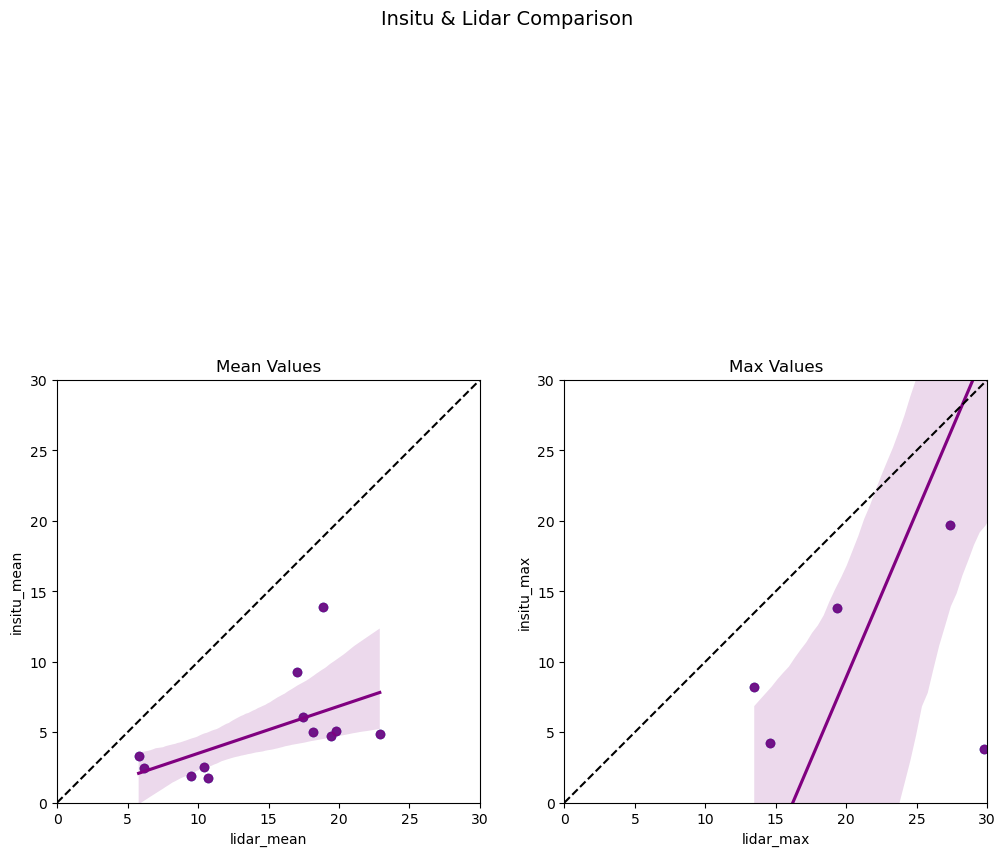

In [118]:
def plot_regression(df):

    # Plot SJER data with regression lines/scatterplot.
    fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,12))
    
    titles = {'SJER', 'SOAP'}          
    i=0
    
    for title in titles:
        suptitle= fig.suptitle('Insitu & Lidar Comparison', fontsize=14)
    
    i+=1
    
    ax1.scatter(df.lidar_mean, df.insitu_mean)
    ax1.set(xlim=(0,30), ylim=(0,30), aspect='equal', title='Mean Values')
    sns.regplot('lidar_mean', 'insitu_mean',
               data=df,
               color='purple',
               ax=ax1)
    ax1.plot((0,1),(0,1), transform=ax1.transAxes, ls='--', c='k')

    ax2.scatter(df.lidar_max, df.insitu_max)
    ax2.set(xlim=(0,30), ylim=(0,30), aspect='equal', title='Max Values')
    sns.regplot('lidar_max', 'insitu_max', 
                data=df, 
                color='purple', 
                ax=ax2)
    ax2.plot((0,1),(0,1), transform=ax2.transAxes, ls='--', c='k')
    
    return df

soap_plot = plot_regression(soap_site.merge_dfs())

C:\Users\rryan\miniconda3\envs\earth-analytics-python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


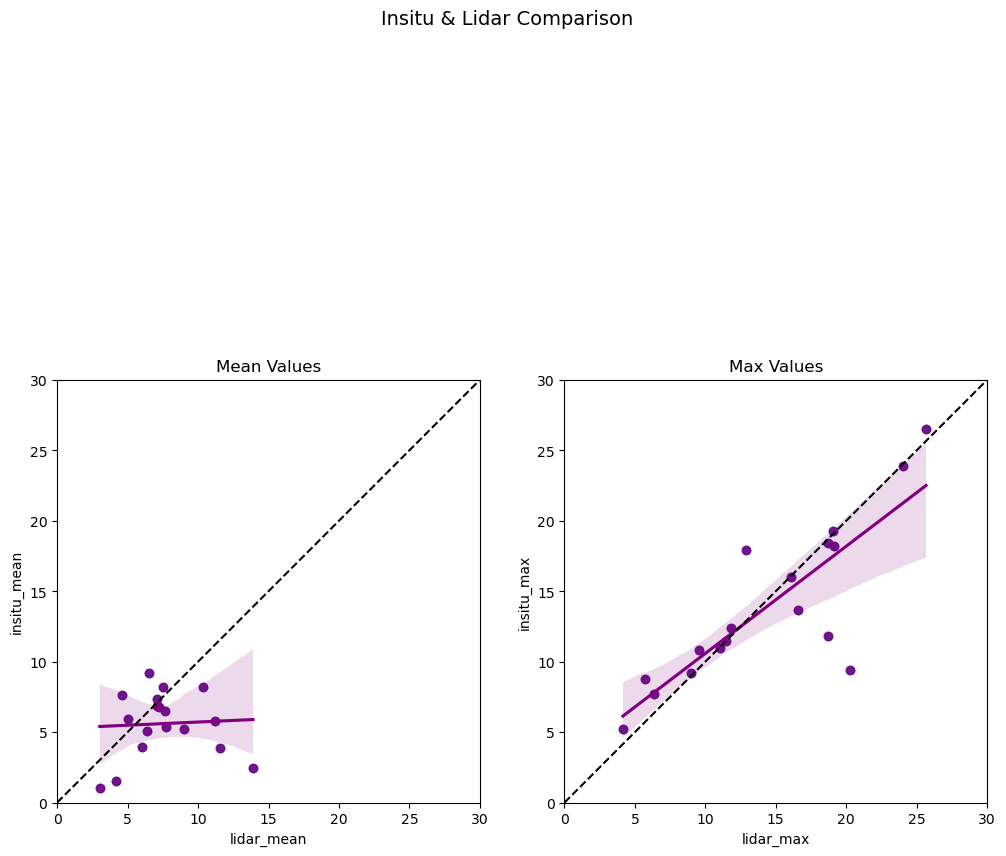

In [121]:
sjer_plot=plot_regression(sjer_site.merge_dfs())